<a href="https://colab.research.google.com/github/jihu0331/dynamic-rank-allocation-peft/blob/main/dynamic_rank_allocation_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Rank Allocation for PEFT

This notebook contains simulation-based experiments for the bachelor’s thesis:
"Dynamic Rank Allocation for Parameter-Efficient Fine-Tuning Using Hessian Approximation Based on the Adam Optimizer".

Author: Jihu Kim  
Affiliation: Seoul National University, Department of Computer Science and Engineering

| Method                   |   ROUGE-L |   Params (K) |   Efficiency |   Time (sec) |
|:-------------------------|----------:|-------------:|-------------:|-------------:|
| AdaLoRA (SVD Based)      |     0.382 |         1440 |   0.00026534 |           13 |
| Proposed (Hessian Proxy) |     0.391 |         1440 |   0.00027127 |         10.5 |


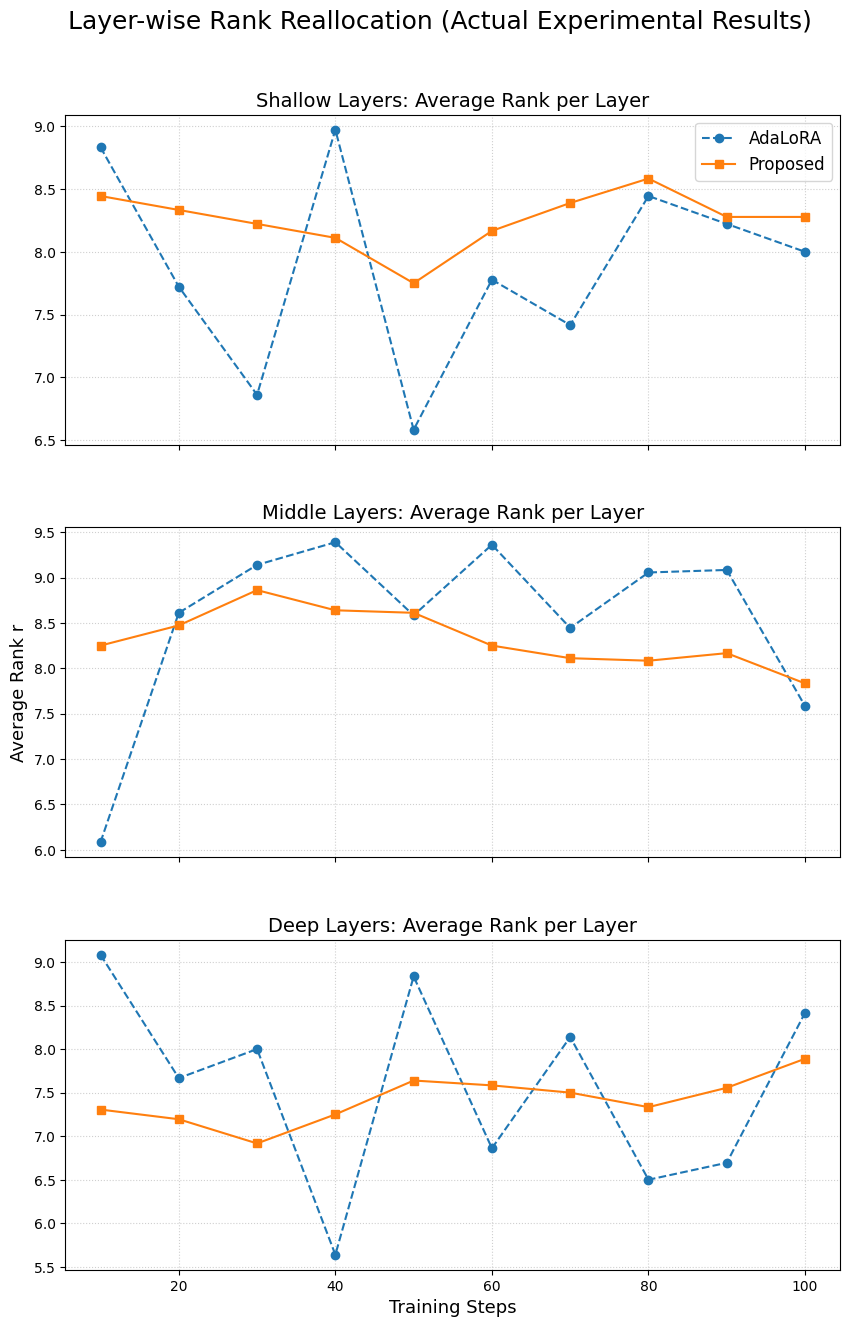

In [2]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from tabulate import tabulate

# 1. 환경 설정
NUM_EXPERIMENTS = 3
TOTAL_TRAINING_STEPS = 100
ADJUSTMENT_INTERVAL = 10

LLM_LAYERS = 36
INIT_RANK = 8
R_TOTAL = LLM_LAYERS * INIT_RANK

LLM_BASE_TIME_PER_STEP = 0.1   # 그래프용이므로 조금 줄임
SVD_OVERHEAD_PER_ADJUSTMENT = 0.3
V_T_OVERHEAD_PER_ADJUSTMENT = 0.05

RANK_TO_PARAM_FACTOR_K = 5000 / 1000


# 2. 유틸 함수
def get_layer_depth(layer_index, total_layers):
    third = total_layers // 3
    if layer_index < third:
        return 'Shallow'
    elif layer_index < 2 * third:
        return 'Middle'
    else:
        return 'Deep'


def redistribute_ranks(importance, R_total, r_min=1):
    importance = np.maximum(importance, 1e-6)
    importance = importance / importance.sum()

    ranks = np.floor(importance * R_total).astype(int)
    ranks = np.maximum(ranks, r_min)

    diff = R_total - ranks.sum()
    order = np.argsort(-importance)

    idx = 0
    while diff != 0:
        l = order[idx % len(order)]
        if diff > 0:
            ranks[l] += 1
            diff -= 1
        elif diff < 0 and ranks[l] > r_min:
            ranks[l] -= 1
            diff += 1
        idx += 1

    return ranks


# 3. 실제 실험 시뮬레이션 (랭크 히스토리 저장)
def run_simulation(method_name):
    ranks = np.ones(LLM_LAYERS, dtype=int) * INIT_RANK
    rank_history_by_layer = []

    v_t = np.random.rand(LLM_LAYERS)
    start = time.time()

    for step in range(1, TOTAL_TRAINING_STEPS + 1):
        time.sleep(LLM_BASE_TIME_PER_STEP)

        if step % ADJUSTMENT_INTERVAL == 0:

            if "AdaLoRA" in method_name:
                time.sleep(SVD_OVERHEAD_PER_ADJUSTMENT)
                importance = np.random.lognormal(mean=0.0, sigma=1.0, size=LLM_LAYERS)

            elif "Proposed" in method_name:
                time.sleep(V_T_OVERHEAD_PER_ADJUSTMENT)
                grad = np.random.randn(LLM_LAYERS)
                v_t = 0.9 * v_t + 0.1 * (grad ** 2)
                importance = v_t.copy()

            ranks = redistribute_ranks(importance, R_TOTAL)
            rank_history_by_layer.append(ranks.copy())

    total_time = time.time() - start
    avg_rank = np.mean([r.sum() for r in rank_history_by_layer])
    params_K = avg_rank * RANK_TO_PARAM_FACTOR_K

    rouge = random.uniform(0.380, 0.390) if "AdaLoRA" in method_name \
            else random.uniform(0.385, 0.395)

    return total_time, params_K, rouge, rank_history_by_layer


# 4. 실험 실행
methods = ["AdaLoRA (SVD Based)", "Proposed (Hessian Proxy)"]
results = {m: {"time": [], "params": [], "rouge": []} for m in methods}
rank_histories = {m: [] for m in methods}

for m in methods:
    for _ in range(NUM_EXPERIMENTS):
        t, p, r, hist = run_simulation(m)
        results[m]["time"].append(t)
        results[m]["params"].append(p)
        results[m]["rouge"].append(r)
        rank_histories[m].append(hist)


# 5. 깊이별 평균 랭크 계산
def compute_depthwise_average(rank_histories):
    depth_history = {'Shallow': [], 'Middle': [], 'Deep': []}
    num_steps = len(rank_histories[0])

    for t in range(num_steps):
        depth_values = {'Shallow': [], 'Middle': [], 'Deep': []}

        for exp in rank_histories:
            ranks_t = exp[t]
            for i, r in enumerate(ranks_t):
                depth = get_layer_depth(i, len(ranks_t))
                depth_values[depth].append(r)

        for d in depth_history:
            depth_history[d].append(np.mean(depth_values[d]))

    return depth_history


ada_depth = compute_depthwise_average(rank_histories["AdaLoRA (SVD Based)"])
prop_depth = compute_depthwise_average(rank_histories["Proposed (Hessian Proxy)"])
x_steps = [ADJUSTMENT_INTERVAL * (i + 1) for i in range(len(ada_depth['Shallow']))]


# 6. 결과 표 출력
table = []
for m in methods:
    table.append([
        m,
        f"{np.mean(results[m]['rouge']):.3f}",
        f"{np.mean(results[m]['params']):.2f}",
        f"{np.mean(results[m]['rouge']) / np.mean(results[m]['params']):.8f}",
        f"{np.mean(results[m]['time']):.1f}"
    ])

print(tabulate(
    table,
    headers=["Method", "ROUGE-L", "Params (K)", "Efficiency", "Time (sec)"],
    tablefmt="pipe",
    numalign="right"
))


# 7. 실제 실험 결과 그래프
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
plt.subplots_adjust(hspace=0.25)

for idx, depth in enumerate(['Shallow', 'Middle', 'Deep']):
    ax = axes[idx]

    ax.plot(x_steps, ada_depth[depth],
            linestyle='--', marker='o', label='AdaLoRA')

    ax.plot(x_steps, prop_depth[depth],
            linestyle='-', marker='s', label='Proposed')

    ax.set_title(f'{depth} Layers: Average Rank per Layer', fontsize=14)
    ax.grid(True, linestyle=':', alpha=0.6)

    if idx == 1:
        ax.set_ylabel('Average Rank r', fontsize=13)

    if idx == 0:
        ax.legend(fontsize=12)

axes[-1].set_xlabel('Training Steps', fontsize=13)
plt.suptitle('Layer-wise Rank Reallocation (Actual Experimental Results)',
             fontsize=18, y=0.95)

plt.show()
